In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from scipy import stats
import math
from sklearn import tree,linear_model,neighbors
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline
import warnings 
warnings.filterwarnings("ignore")
sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":10,"axes.titlesize":24,"axes.labelsize":24}) 
from sklearn import model_selection

# Upload data (customers model)

In [4]:
train=pd.read_csv('TrainClean.csv',index_col=0).reset_index(drop=True)
#test=pd.read_csv('TestClean.csv',index_col=0).reset_index(drop=True)

columnscustomers_lasso=['HasPromotions', 'NearestCompetitor', 'Region_AreaKM2',
       'Mean_Dew_PointC', 'Mean_Sea_Level_PressurehPa', 'Precipitationmm',
       'StandardMarket', 'HyperMarket', 'ShoppingCenter', 'General',
       'WithFishDepartment', 'Region0', 'Region1', 'Region3', 'Region4',
       'Region5', 'Region6', 'Region7', 'Region8', 'Region9', 'January',
       'February', 'April', 'May', 'June', 'September', 'October', 'November',
       'December', 'Wednesday', 'Friday', 'Saturday', 'Monday', 'Thursday',
       'Fog', 'Snow']
columnssales_lasso=['IsHoliday', 'HasPromotions', 'NearestCompetitor', 'Region_AreaKM2',
       'Region_PopulationK', 'Mean_Humidity', 'Mean_Sea_Level_PressurehPa',
       'Mean_TemperatureC', 'Mean_VisibilityKm', 'Precipitationmm',
       'StandardMarket', 'HyperMarket', 'SuperMarket', 'ShoppingCenter',
       'WithFishDepartment', 'WithNonFoodDepartment', 'Region0', 'Region1',
       'Region2', 'Region3', 'Region4', 'Region6', 'Region7', 'Region8',
       'January', 'February', 'March', 'April', 'May', 'June', 'July',
       'September', 'October', 'November', 'December', 'Tuesday', 'Friday',
       'Saturday', 'Monday', 'Thursday', 'Sunday', 'Fog', 'Snow', 'Nothing',
       'Rain', 'Thunderstorm', 'NumberOfCustomers']
columnsdirect_lasso=['HasPromotions', 'NearestCompetitor', 'Region_GDP', 'Mean_Dew_PointC',
       'Mean_Sea_Level_PressurehPa', 'Precipitationmm', 'HyperMarket',
       'ShoppingCenter', 'General', 'Region0', 'Region2', 'Region3', 'Region4',
       'Region5', 'Region6', 'Region8', 'Region9', 'January', 'May', 'June',
       'September', 'October', 'November', 'December', 'Tuesday', 'Wednesday',
       'Friday', 'Saturday', 'Monday']
columnscustomers_rfs=['NearestCompetitor', 'ShoppingCenter', 'Region3', 'HasPromotions',
       'StandardMarket', 'Region7', 'General', 'Region_AreaKM2', 'Region_GDP',
       'WithNonFoodDepartment', 'HyperMarket', 'SuperMarket', 'Monday',
       'December', 'Saturday', 'Region8', 'Region_PopulationK', 'Region0',
       'Region9', 'Region2', 'Mean_Sea_Level_PressurehPa', 'Mean_Humidity',
       'Region4', 'Mean_Dew_PointC', 'Mean_VisibilityKm']
columnssales_rfs=['NumberOfCustomers', 'HasPromotions', 'NearestCompetitor',
       'StandardMarket', 'Monday', 'General', 'December', 'Region_AreaKM2',
       'Region3', 'Region_GDP', 'Region_PopulationK', 'WithNonFoodDepartment',
       'HyperMarket', 'Region2', 'ShoppingCenter', 'Saturday', 'Region9',
       'SuperMarket', 'Region6', 'Region5', 'Region7', 'Region0',
       'WithFishDepartment', 'Mean_Sea_Level_PressurehPa', 'Mean_VisibilityKm']
direcly_sales_rfs = ['NearestCompetitor', 'HasPromotions', 'General', 'HyperMarket',
       'December', 'Region3', 'Monday', 'Region_GDP', 'ShoppingCenter',
       'Region_AreaKM2', 'Saturday', 'Region_PopulationK', 'StandardMarket',
       'SuperMarket', 'Mean_Sea_Level_PressurehPa', 'Region9',
       'Mean_VisibilityKm', 'Mean_Humidity', 'Region7', 'Mean_Dew_PointC', 'H',
       'Mean_Wind_SpeedKm_h', 'Mean_TemperatureC', 'WCI', 'Region5']

# Function definition

In [14]:
def BoostingCrossvalidation(dataset, features, target, no_boosting_runs):
    
    dataset_size = dataset.shape[0]
    crossperf = []
    r2mean = []
    dataset = dataset.sample(frac=1,random_state=1234)
    k = 3
    step = math.floor(dataset_size/k)
    
    for i in range(0,dataset_size,step+1):
        perf = []
        model_list = []
        
        train_data, test_data = DataSplit(dataset,i,step)
    
        x = train_data[features]
        y_residual = train_data[target].values.reshape(-1,1)    
        x_test = test_data[features]
        y_test = test_data[target].values.reshape(-1,1)
    
        for i in range(no_boosting_runs):
            y_residual,yp_boosting = DT_FittingAndEvaluation(x, x_test, y_residual, y_test, perf, model_list)
        
        y =  train_data[target]
        model1 = RandomForestRegressor(random_state=12345) 
        model1.set_params(n_estimators=150,min_samples_leaf=5)
        model1.fit(x,y)
        
        yp_forest = model1.predict(x_test)
        
        mean_predictions = []
        
        for i in range(yp_forest.shape[0]):
            mean_predictions.append((yp_boosting[i]+yp_forest[i])/2)
    
        r2mean.append(r2_score(y_test,mean_predictions))
        crossperf.append(perf)
    
    return crossperf,r2mean

In [5]:
def DataSplit(dataset,i,step):
    left_data = dataset[0:i]
    test_data = dataset[i:i+step]
    right_data = dataset[i+step+1:dataset.shape[0]]        
    train_data = left_data.append(right_data)
    train_data = train_data.reset_index(drop=True)
    return train_data, test_data

In [6]:
def DT_FittingAndEvaluation(x, x_test, y_residual, y_test, perf, model_list):
    y_residual = DT_Fitting(x, y_residual, model_list)
    result=GradientBoosting_eval(model_list,x_test)
    perf.append(r2_score(y_test,result))
    perf[-20:]
    return y_residual,result

In [7]:
def DT_Fitting(x, y_residual, model_list):
    clf = tree.DecisionTreeRegressor(max_depth=6)
    clf = clf.fit(x, y_residual)
    model_list.append(clf)
    yp = clf.predict(x).reshape(-1,1)
    y_residual = y_residual-yp
    return y_residual

In [8]:
def GradientBoosting_eval(models,data_to_predict):
    prediction = np.zeros((len(data_to_predict),1))
    for model in models:
        yp = model.predict(data_to_predict).reshape(-1,1)
        prediction += yp
    return prediction.reshape(-1,1)

In [9]:
def GradientBoosting_performances(crossperf):
    finalperf = []
    for i in range(len(crossperf[0])):
        perflist=[]
        for performance in crossperf:
            perflist.append(performance[i])
        finalperf.append(np.average(perflist))
        del perflist
        print("Boosting %d : %d modelli - R2: %f\n" % (i,i+1,finalperf[i]))
    plt.plot(finalperf)

## Prediction functions

In [10]:
def DoubleBoostingCrossvalidation(dataset, first_features, first_target, second_features, second_target, no_boosting_runs):
    
    dataset_size = dataset.shape[0]
    crossperf = []
    dataset = dataset.sample(frac=1,random_state=1234)
    k = 3
    step = math.floor(dataset_size/k)
    
    for i in range(0,dataset_size,step+1):
        perf = [] 
        model_list = []
    
        train_data, test_data = DataSplit(dataset,i,step)
        
        x = train_data[first_features]
        y_residual = train_data[first_target].values.reshape(-1,1)    
        x_test = test_data[first_features]
        y_test = test_data[first_target].values.reshape(-1,1)
    
        for i in range(no_boosting_runs):
            y_residual = DT_FittingAndEvaluation(x, x_test, y_residual, y_test, perf, model_list)
        
        predicted_cust = GradientBoosting_eval(model_list,x)
        predicted_cust_test = GradientBoosting_eval(model_list,x_test)
        
        perf = [] 
        model_list = []
        
        x = train_data[second_features]
        y_residual = train_data[second_target].values.reshape(-1,1)    
        x_test = test_data[second_features].drop(columns='NumberOfCustomers',axis=1) 
        x_test['NumberOfCustomers'] = predicted_cust_test       #test should be evaluated on predicted customers
        y_test = test_data[second_target].values.reshape(-1,1)
        
        for i in range(no_boosting_runs):
            y_residual = DT_FittingAndEvaluation(x, x_test, y_residual, y_test, perf, model_list)
        
        crossperf.append(perf)
    
    return crossperf

In [11]:
## Not used yet, useful for future customers prediction for delivery
def Model_Building(dataset, features, target, no_boosting_runs):
    model_list = []
    
    x = dataset[features]
    y_residual = dataset[target].values.reshape(-1,1)    
    
    prediction = np.zeros((len(y),1))
    
    for i in range(no_boosting_runs):
        y_residual = DT_Fitting(x, y_residual, model_list)
    
    return model_list

# Predict Sales direclty

### No Features Selection

In [12]:
all_features = train.drop(columns=['NumberOfSales','NumberOfCustomers']).columns

In [15]:
crossperf,meanperf = BoostingCrossvalidation(train,all_features,'NumberOfSales',130)

In [25]:
np.average([crossperf[0][129] , crossperf[1][129] , crossperf[2][129]])

0.8483283792414286

In [26]:
np.average(meanperf)

0.8681417308283904

In [ ]:
print("CIAO")

Boosting 0 : 1 modelli - R2: 0.331507

Boosting 1 : 2 modelli - R2: 0.398054

Boosting 2 : 3 modelli - R2: 0.436168

Boosting 3 : 4 modelli - R2: 0.463825

Boosting 4 : 5 modelli - R2: 0.484887

Boosting 5 : 6 modelli - R2: 0.500657

Boosting 6 : 7 modelli - R2: 0.533076

Boosting 7 : 8 modelli - R2: 0.557939

Boosting 8 : 9 modelli - R2: 0.575087

Boosting 9 : 10 modelli - R2: 0.600847

Boosting 10 : 11 modelli - R2: 0.624068

Boosting 11 : 12 modelli - R2: 0.646144

Boosting 12 : 13 modelli - R2: 0.664406

Boosting 13 : 14 modelli - R2: 0.681719

Boosting 14 : 15 modelli - R2: 0.691275

Boosting 15 : 16 modelli - R2: 0.696637

Boosting 16 : 17 modelli - R2: 0.704575

Boosting 17 : 18 modelli - R2: 0.713102

Boosting 18 : 19 modelli - R2: 0.723980

Boosting 19 : 20 modelli - R2: 0.731277

Boosting 20 : 21 modelli - R2: 0.739573

Boosting 21 : 22 modelli - R2: 0.745751

Boosting 22 : 23 modelli - R2: 0.750856

Boosting 23 : 24 modelli - R2: 0.757618

Boosting 24 : 25 modelli - R2: 0.76

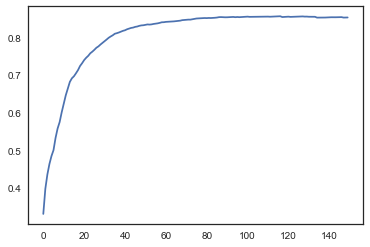

In [34]:
crossperf = BoostingCrossvalidation(train, all_features, 'NumberOfSales', 150)

GradientBoosting_performances(crossperf)

### Lasso Features Selection

Boosting 0 : 1 modelli - R2: 0.316040

Boosting 1 : 2 modelli - R2: 0.395165

Boosting 2 : 3 modelli - R2: 0.433807

Boosting 3 : 4 modelli - R2: 0.461828

Boosting 4 : 5 modelli - R2: 0.499939

Boosting 5 : 6 modelli - R2: 0.516183

Boosting 6 : 7 modelli - R2: 0.543268

Boosting 7 : 8 modelli - R2: 0.568714

Boosting 8 : 9 modelli - R2: 0.589749

Boosting 9 : 10 modelli - R2: 0.606958

Boosting 10 : 11 modelli - R2: 0.616096

Boosting 11 : 12 modelli - R2: 0.642738

Boosting 12 : 13 modelli - R2: 0.659165

Boosting 13 : 14 modelli - R2: 0.673572

Boosting 14 : 15 modelli - R2: 0.686925

Boosting 15 : 16 modelli - R2: 0.698247

Boosting 16 : 17 modelli - R2: 0.703434

Boosting 17 : 18 modelli - R2: 0.707920

Boosting 18 : 19 modelli - R2: 0.715044

Boosting 19 : 20 modelli - R2: 0.723698

Boosting 20 : 21 modelli - R2: 0.730018

Boosting 21 : 22 modelli - R2: 0.740449

Boosting 22 : 23 modelli - R2: 0.747938

Boosting 23 : 24 modelli - R2: 0.753818

Boosting 24 : 25 modelli - R2: 0.75

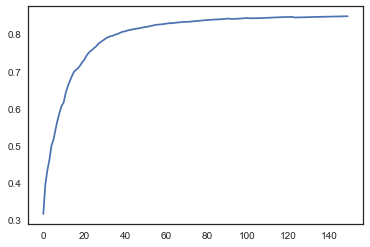

In [35]:
crossperf = BoostingCrossvalidation(train, columnsdirect_lasso, 'NumberOfSales', 150)

GradientBoosting_performances(crossperf)

### Random Forest Selection

Boosting 0 : 1 modelli - R2: 0.331095

Boosting 1 : 2 modelli - R2: 0.405168

Boosting 2 : 3 modelli - R2: 0.448001

Boosting 3 : 4 modelli - R2: 0.486849

Boosting 4 : 5 modelli - R2: 0.515773

Boosting 5 : 6 modelli - R2: 0.552049

Boosting 6 : 7 modelli - R2: 0.585239

Boosting 7 : 8 modelli - R2: 0.602300

Boosting 8 : 9 modelli - R2: 0.625246

Boosting 9 : 10 modelli - R2: 0.642164

Boosting 10 : 11 modelli - R2: 0.658841

Boosting 11 : 12 modelli - R2: 0.674076

Boosting 12 : 13 modelli - R2: 0.687373

Boosting 13 : 14 modelli - R2: 0.698987

Boosting 14 : 15 modelli - R2: 0.709644

Boosting 15 : 16 modelli - R2: 0.721417

Boosting 16 : 17 modelli - R2: 0.732314

Boosting 17 : 18 modelli - R2: 0.739857

Boosting 18 : 19 modelli - R2: 0.743912

Boosting 19 : 20 modelli - R2: 0.749008

Boosting 20 : 21 modelli - R2: 0.752827

Boosting 21 : 22 modelli - R2: 0.755204

Boosting 22 : 23 modelli - R2: 0.759300

Boosting 23 : 24 modelli - R2: 0.763578

Boosting 24 : 25 modelli - R2: 0.76

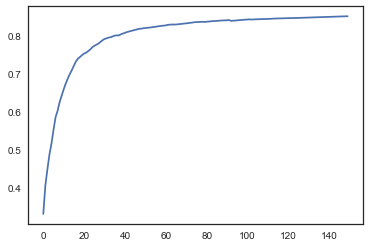

In [36]:
crossperf = BoostingCrossvalidation(train, direcly_sales_rfs, 'NumberOfSales', 150)

GradientBoosting_performances(crossperf)

# Double Prediction

Boosting 0 : 1 modelli - R2: 0.682549

Boosting 1 : 2 modelli - R2: 0.708844

Boosting 2 : 3 modelli - R2: 0.716993

Boosting 3 : 4 modelli - R2: 0.723449

Boosting 4 : 5 modelli - R2: 0.729239

Boosting 5 : 6 modelli - R2: 0.735536

Boosting 6 : 7 modelli - R2: 0.740420

Boosting 7 : 8 modelli - R2: 0.744387

Boosting 8 : 9 modelli - R2: 0.750770

Boosting 9 : 10 modelli - R2: 0.753544

Boosting 10 : 11 modelli - R2: 0.755386

Boosting 11 : 12 modelli - R2: 0.757268

Boosting 12 : 13 modelli - R2: 0.758492

Boosting 13 : 14 modelli - R2: 0.761211

Boosting 14 : 15 modelli - R2: 0.763656

Boosting 15 : 16 modelli - R2: 0.766014

Boosting 16 : 17 modelli - R2: 0.769603

Boosting 17 : 18 modelli - R2: 0.771427

Boosting 18 : 19 modelli - R2: 0.771892

Boosting 19 : 20 modelli - R2: 0.773514

Boosting 20 : 21 modelli - R2: 0.775073

Boosting 21 : 22 modelli - R2: 0.775615

Boosting 22 : 23 modelli - R2: 0.777387

Boosting 23 : 24 modelli - R2: 0.778188

Boosting 24 : 25 modelli - R2: 0.77

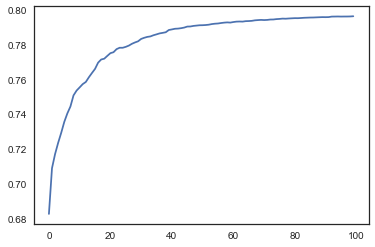

In [37]:
crossperf = DoubleBoostingCrossvalidation(train, columnscustomers_lasso, 'NumberOfCustomers', columnssales_lasso, 'NumberOfSales', 100)
GradientBoosting_performances(crossperf)

Boosting 0 : 1 modelli - R2: 0.331095

Boosting 1 : 2 modelli - R2: 0.405163

Boosting 2 : 3 modelli - R2: 0.447995

Boosting 3 : 4 modelli - R2: 0.486843

Boosting 4 : 5 modelli - R2: 0.515768

Boosting 5 : 6 modelli - R2: 0.552043

Boosting 6 : 7 modelli - R2: 0.585233

Boosting 7 : 8 modelli - R2: 0.602291

Boosting 8 : 9 modelli - R2: 0.625238

Boosting 9 : 10 modelli - R2: 0.642156

Boosting 10 : 11 modelli - R2: 0.658839

Boosting 11 : 12 modelli - R2: 0.674074

Boosting 12 : 13 modelli - R2: 0.687372

Boosting 13 : 14 modelli - R2: 0.698985

Boosting 14 : 15 modelli - R2: 0.709642

Boosting 15 : 16 modelli - R2: 0.721415

Boosting 16 : 17 modelli - R2: 0.732314

Boosting 17 : 18 modelli - R2: 0.739856

Boosting 18 : 19 modelli - R2: 0.743911

Boosting 19 : 20 modelli - R2: 0.749005

Boosting 20 : 21 modelli - R2: 0.752826

Boosting 21 : 22 modelli - R2: 0.755201

Boosting 22 : 23 modelli - R2: 0.759310

Boosting 23 : 24 modelli - R2: 0.763590

Boosting 24 : 25 modelli - R2: 0.76

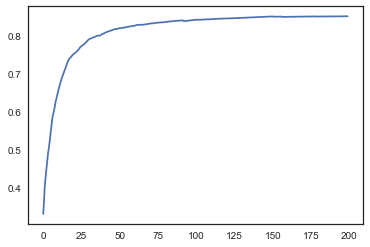

In [39]:
crossperf = BoostingCrossvalidation(train, direcly_sales_rfs, 'NumberOfSales', 200)

GradientBoosting_performances(crossperf)